#### Libraries

In [1]:
import pandas as pd
import numpy as np
import backtesting_base_mostoro as back
from datetime import time
from datetime import time, timedelta


In [ ]:
x = pd.read_csv(r'/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/Data/MES_01_2023_09_2023_nine_months.csv')
x

In [ ]:

#Parameters to get data from backtesting base class
year = 2025
symbol = 'MES'
# start  = '2023-10-15' # it could be useful to fiter the data
# end    = '2023-10-27' # it could be useful to fiter the data
amount = 5000
bar_time = '1min'
stop_loss = 4
target = 8
#Calling backtesting base class to get some variables
backtesting_base = back.Backtesting(symbol, amount, bar_time, stop_loss, target) # calling backtesting base
# data_intraday = backtesting_base.data
ticks = backtesting_base.data

In [ ]:
# data_intraday
ticks = backtesting_base.data_ticks.reset_index()
ticks

### Getting Footprint

In [2]:
import pandas as pd 
# ticks = pd.read_csv(r'/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/Data/archive/Initiative (Volume Profile)/Drafts/MES_02_2025.csv')

ticks = pd.read_csv(r'/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/Data/MES_01_2023_09_2023_nine_months.csv')

ticks

,Date,Last,Bid_Volume,Ask_Volume,Volume
0,2023-01-02 18:00:00,3885.75,0,0,0
1,2023-01-02 18:00:00,3886.00,2,0,2
2,2023-01-02 18:00:00,3886.00,1,0,1
3,2023-01-02 18:00:00,3886.00,2,0,2
4,2023-01-02 18:00:00,3886.25,1,0,1
...,...,...,...,...,...
93184262,2023-09-29 16:59:59,4329.25,0,1,1
93184263,2023-09-29 16:59:59,4329.25,0,3,3
93184264,2023-09-29 16:59:59,4329.25,0,1,1
93184265,2023-09-29 16:59:59,4329.25,0,1,1


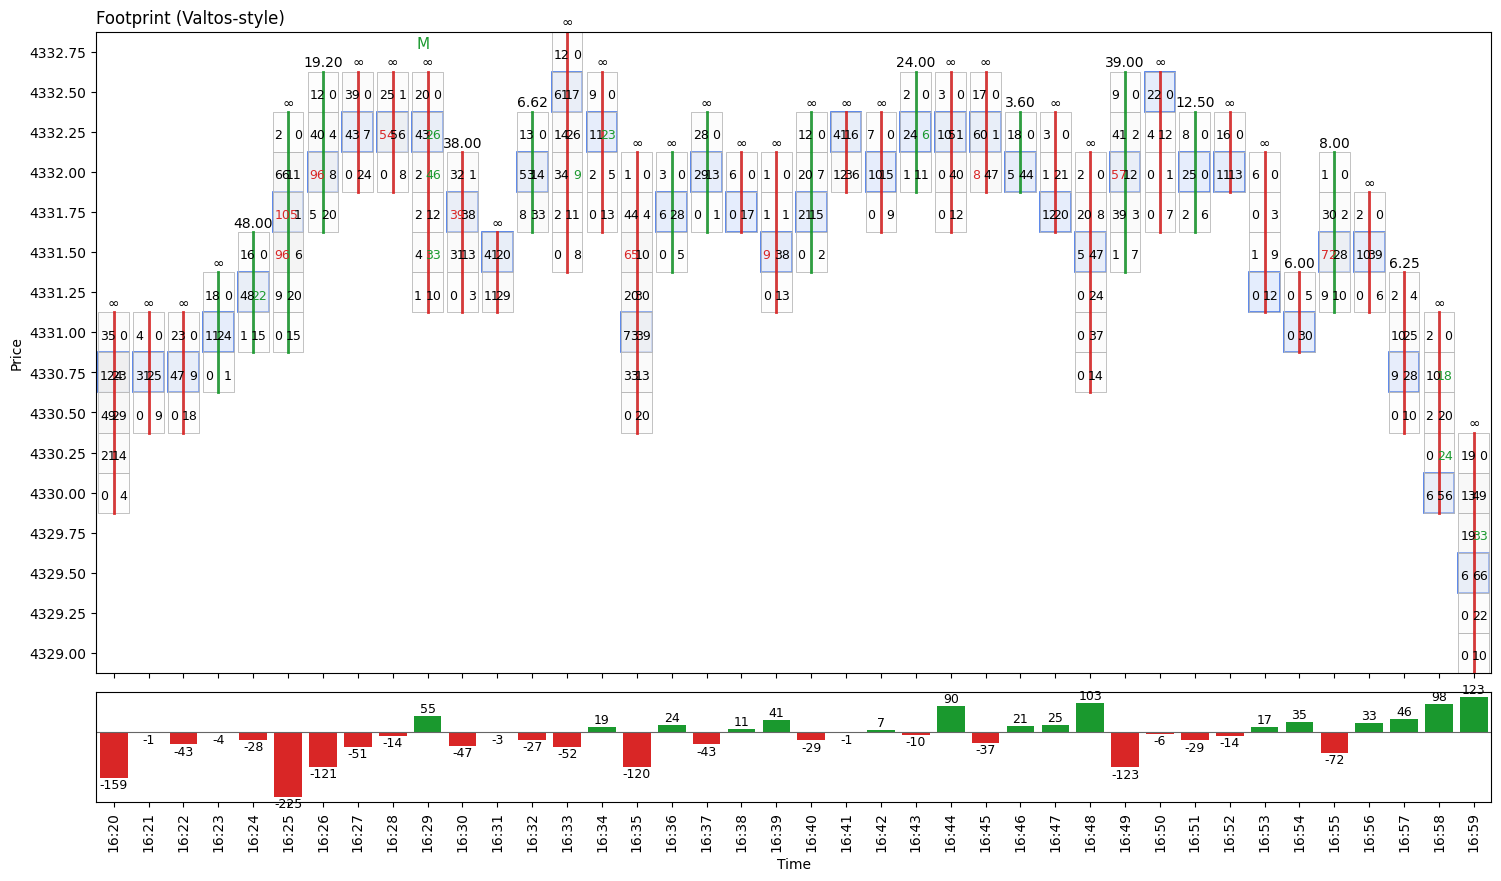

In [3]:
# ===============================================
# Valtos-style Footprint — SINGLE CELL FROM `ticks`
# ===============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import gridspec

# -------------------------
# Config
# -------------------------
BAR_SIZE        = '1min'   # change to your bar size (e.g., '30s', '2min')
TICK_SIZE       = 0.25     # instrument tick size
IMB_RATIO       = 4.0      # diagonal imbalance ratio
REQUIRE_CP_GT0  = True     # require counterpart > 0
STACK_MIN       = 3        # consecutive levels for "S"
MULTI_IMB_N     = 3        # total imbalances for "M"
N_BARS_TO_PLOT  = 40
FIGSIZE         = (18, 10)
FONT_SIZE       = 9
BAR_GAP         = 0.12
BARLINE_WIDTH   = 2.0
VOL_ALPHA_FLOOR = 0.08

# -------------------------
# Helper: OHLC from ticks
# -------------------------
def build_ohlc_from_ticks(ticks: pd.DataFrame, bar=BAR_SIZE) -> pd.DataFrame:
    t = ticks.copy()
    if not np.issubdtype(t['Date'].dtype, np.datetime64):
        t['Date'] = pd.to_datetime(t['Date'])
    t['BarTime'] = t['Date'].dt.floor(bar)

    t_sorted = t.sort_values('Date')
    open_  = t_sorted.groupby('BarTime')['Last'].first()
    close_ = t_sorted.groupby('BarTime')['Last'].last()
    high_  = t.groupby('BarTime')['Last'].max()
    low_   = t.groupby('BarTime')['Last'].min()

    ohlc = pd.DataFrame({'Open': open_, 'High': high_, 'Low': low_, 'Close': close_}).reset_index()
    return ohlc

# -------------------------
# Build `bars` and `foot` from ticks
# -------------------------
def build_bars_and_foot_from_ticks(ticks: pd.DataFrame,
                                   tick_size=TICK_SIZE,
                                   bar=BAR_SIZE):
    t = ticks.copy()
    if not np.issubdtype(t['Date'].dtype, np.datetime64):
        t['Date'] = pd.to_datetime(t['Date'])
    t['BarTime'] = t['Date'].dt.floor(bar)

    # Normalize trade price to the tick grid (if already aligned, this keeps it)
    t['Price'] = (np.round(t['Last'] / tick_size) * tick_size).astype(float)

    # --- foot (per BarTime x Price) ---
    grp = t.groupby(['BarTime','Price'], as_index=False).agg(
        Bid_Volume=('Bid_Volume','sum'),
        Ask_Volume=('Ask_Volume','sum'),
        Total=('Volume','sum'),
    )
    foot = grp.sort_values(['BarTime','Price']).reset_index(drop=True)

    # --- bars (per BarTime) ---
    bb = t.groupby('BarTime').agg(
        PriceMin=('Price','min'),
        PriceMax=('Price','max'),
        BidSum=('Bid_Volume','sum'),
        AskSum=('Ask_Volume','sum'),
        Vol=('Volume','sum'),
    ).reset_index()
    bb['BarDelta'] = (bb['AskSum'] - bb['BidSum']).astype(int)

    # POC (price of max Total within each bar)
    poc = foot.groupby(['BarTime','Price'])['Total'].sum().reset_index()
    poc = poc.sort_values(['BarTime','Total']).groupby('BarTime').tail(1)
    bb = bb.merge(poc[['BarTime','Price']].rename(columns={'Price':'POC_Price'}), on='BarTime', how='left')

    # Add OHLC (from raw ticks) for proper bull/bear classification
    ohlc = build_ohlc_from_ticks(t, bar=bar)
    bars = bb.merge(ohlc, on='BarTime', how='left').sort_values('BarTime').reset_index(drop=True)

    return bars, foot, ohlc

# -------------------------
# Valtos ratio features
# -------------------------
def _two_levels_side(vals_by_price: dict, t, penultimate_price, last_price):
    pen = float(vals_by_price.get((str(t), penultimate_price), 0.0))
    last = float(vals_by_price.get((str(t), last_price), 0.0))
    return pen, last

def build_valtos_features(foot: pd.DataFrame,
                          bars: pd.DataFrame,
                          tick_size=TICK_SIZE) -> pd.DataFrame:
    f = foot[['BarTime','Price','Bid_Volume','Ask_Volume']].copy()
    key = list(zip(f['BarTime'].astype(str), f['Price']))
    bid_at = dict(zip(key, f['Bid_Volume']))
    ask_at = dict(zip(key, f['Ask_Volume']))

    rows = []
    for _, row in bars.iterrows():
        t   = row['BarTime']
        low = row['PriceMin']
        high= row['PriceMax']
        op  = row['Open']
        cl  = row['Close']

        bullish = (pd.notna(op) and pd.notna(cl) and cl > op)
        bearish = (pd.notna(op) and pd.notna(cl) and cl < op)

        if bullish:
            pen, last = _two_levels_side(bid_at, t, round(low + tick_size, 10), low)
        elif bearish:
            pen, last = _two_levels_side(ask_at, t, round(high - tick_size, 10), high)
        else:
            pen, last = (np.nan, np.nan)

        # ratio metrics (penultimate / last) — ∞ if last==0 and penultimate>0
        # ratio_last = last
        # ratio_diff = np.nan if (np.isnan(pen) or np.isnan(last)) else abs(pen - last)

        if np.isnan(pen) or np.isnan(last):
            ratio_frac = np.nan
        elif last == 0:
            ratio_frac = np.inf if pen > 0 else np.nan
        else:
            ratio_frac = pen / last

        rows.append({
            'BarTime'    : t,
            'Open'       : op,
            'Close'      : cl,
            'Delta'      : int(row.get('BarDelta', 0)),
            'POC'        : row.get('POC_Price', np.nan),
            # 'Ratio_last' : ratio_last,
            # 'Ratio_diff' : ratio_diff,
            'Ratio_frac' : ratio_frac,
        })
    return pd.DataFrame(rows)

# -------------------------
# Imbalances by side from `foot`
# -------------------------
def _max_run(bool_series: pd.Series) -> int:
    run = m = 0
    for v in bool_series.astype(bool).tolist():
        run = run + 1 if v else 0
        m = max(m, run)
    return m

def compute_bar_imbalances_from_foot(foot: pd.DataFrame,
                                     imb_ratio: float = IMB_RATIO,
                                     require_counterpart_gt0: bool = REQUIRE_CP_GT0) -> pd.DataFrame:
    f = foot[['BarTime','Price','Bid_Volume','Ask_Volume']].copy()
    f = f.sort_values(['BarTime','Price']).reset_index(drop=True)

    # diagonal counterparts
    f['Bid_dn'] = f.groupby('BarTime')['Bid_Volume'].shift(1)   # Bid@(P-1) vs Ask@P
    f['Ask_up'] = f.groupby('BarTime')['Ask_Volume'].shift(-1)  # Ask@(P+1) vs Bid@P

    if require_counterpart_gt0:
        f['LongImb']  = (f['Ask_Volume'] >= imb_ratio * f['Bid_dn']) & (f['Bid_dn'] > 0)
        f['ShortImb'] = (f['Bid_Volume'] >= imb_ratio * f['Ask_up']) & (f['Ask_up'] > 0)
    else:
        f['LongImb']  = (f['Ask_Volume']  >= imb_ratio * f['Bid_dn'].fillna(0))
        f['ShortImb'] = (f['Bid_Volume'] >= imb_ratio * f['Ask_up'].fillna(0))

    counts = f.groupby('BarTime').agg(
        LongImbCount=('LongImb','sum'),
        ShortImbCount=('ShortImb','sum'),
    )
    runs_long  = f.groupby('BarTime')['LongImb'].apply(_max_run).rename('LongMaxImbLevels')
    runs_short = f.groupby('BarTime')['ShortImb'].apply(_max_run).rename('ShortMaxImbLevels')

    out = counts.join(runs_long).join(runs_short).reset_index()
    for c in ['LongImbCount','ShortImbCount','LongMaxImbLevels','ShortMaxImbLevels']:
        out[c] = out[c].fillna(0).astype(int)
    return out

# -------------------------
# Renderer
# -------------------------
def render_valtos_footprint(
    foot: pd.DataFrame,
    bars: pd.DataFrame,
    bt: pd.DataFrame,
    *,
    n_bars: int = N_BARS_TO_PLOT,
    tick_size: float = TICK_SIZE,
    imbalance_ratio: float = IMB_RATIO,
    require_counterpart_gt0: bool = REQUIRE_CP_GT0,
    stack_min: int = STACK_MIN,
    multi_imb_n: int = MULTI_IMB_N,
    font_size: int = FONT_SIZE,
    figsize: tuple = FIGSIZE,
    vol_alpha_floor: float = VOL_ALPHA_FLOOR,
    bar_gap: float = BAR_GAP,
    barline_width: float = BARLINE_WIDTH,
    show_delta_panel: bool = True
):
    # select window
    bars_ = bars.sort_values("BarTime").tail(n_bars).reset_index(drop=True)
    times = list(pd.to_datetime(bars_["BarTime"]))
    f = foot[foot["BarTime"].isin(times)].copy().sort_values(["BarTime","Price"]).reset_index(drop=True)

    bt_ = bt[bt["BarTime"].isin(times)].sort_values("BarTime").reset_index(drop=True)
    bt_map = bt_.set_index('BarTime')

    # ladder
    pmin, pmax = f["Price"].min(), f["Price"].max()
    ladder = np.arange(pmin, pmax + tick_size, tick_size)
    price_to_row = {p:i for i,p in enumerate(ladder)}

    # POC
    poc_by_time = (
        f.groupby(["BarTime","Price"])["Total"].sum()
         .reset_index()
         .sort_values(["BarTime","Total"])
         .groupby("BarTime").tail(1)
         .set_index("BarTime")["Price"]
    )

    # lookups for digits
    key = list(zip(f["BarTime"].astype(str), f["Price"]))
    d_bid = dict(zip(key, f["Bid_Volume"]))
    d_ask = dict(zip(key, f["Ask_Volume"]))
    d_tot = dict(zip(key, f["Total"]))

    # diagonal counterparts
    f = f.sort_values(["BarTime","Price"]).reset_index(drop=True)
    f['Bid_dn'] = f.groupby('BarTime')['Bid_Volume'].shift(1)
    f['Ask_up'] = f.groupby('BarTime')['Ask_Volume'].shift(-1)
    d_bid_dn = dict(zip(key, f['Bid_dn'].fillna(0)))
    d_ask_up = dict(zip(key, f['Ask_up'].fillna(0)))

    vmax = max(1.0, f["Total"].max())

    # figure
    if show_delta_panel:
        fig = plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(2, 1, height_ratios=[7, 1.2], hspace=0.05)
        ax  = fig.add_subplot(gs[0])
        axd = fig.add_subplot(gs[1], sharex=ax)
    else:
        fig, ax = plt.subplots(figsize=figsize); axd = None

    cell_w = 1.0 - bar_gap
    ax.set_xlim(-0.5, len(times)-0.5)
    ax.set_ylim(-0.5, len(ladder)-0.5)
    step = max(1, len(ladder)//12)
    ax.set_yticks(range(0, len(ladder), step))
    ax.set_yticklabels([f"{p:.2f}" for p in ladder[::step]])
    ax.set_xticks(range(len(times)))
    ax.set_xticklabels([pd.to_datetime(t).strftime("%H:%M") for t in times], rotation=90)
    ax.set_title("Footprint (Valtos-style)", loc="left", fontsize=12)
    ax.grid(False)

    # colors
    buy_color   = (0.10,0.60,0.18,1.0)
    sell_color  = (0.85,0.15,0.15,1.0)
    neutral_edge= (0.72,0.72,0.72,1.0)

    rects, facecolors, edgecolors, linewidths = [], [], [], []

    for x, t in enumerate(times):
        # center colored line by Close>Open
        o = bt_map.at[t, 'Open']  if (t in bt_map.index and 'Open'  in bt_map.columns) else np.nan
        c = bt_map.at[t, 'Close'] if (t in bt_map.index and 'Close' in bt_map.columns) else np.nan
        bull = bool(c > o) if np.all(pd.notna([o,c])) else (int(bars_.loc[x,'BarDelta']) >= 0)

        y0  = price_to_row[bars_.loc[x, "PriceMin"]] - 0.5
        y1  = price_to_row[bars_.loc[x, "PriceMax"]] + 0.5
        ax.plot([x, x], [y0, y1], color=(buy_color if bull else sell_color),
                linewidth=barline_width, alpha=0.95)

        # cells
        for p in ladder:
            r = price_to_row[p]
            bid = d_bid.get((str(t), p), 0.0)
            ask = d_ask.get((str(t), p), 0.0)
            tot = d_tot.get((str(t), p), 0.0)
            if tot<=0 and bid==0 and ask==0:
                continue

            rect = Rectangle((x - cell_w/2, r-0.5), cell_w, 1.0)
            rects.append(rect)
            alpha = max(VOL_ALPHA_FLOOR, min(0.95, tot / vmax))
            facecolors.append((0.94,0.94,0.94, alpha))
            edgecolors.append(neutral_edge); linewidths.append(0.6)

            # diagonal imbalance digit-coloring
            bid_dn = d_bid_dn.get((str(t), p), 0.0)
            ask_up = d_ask_up.get((str(t), p), 0.0)
            long_ok  = (ask >= imbalance_ratio * bid_dn) and ((bid_dn > 0) if require_counterpart_gt0 else True)
            short_ok = (bid >= imbalance_ratio * ask_up) and ((ask_up > 0) if require_counterpart_gt0 else True)

            if p == poc_by_time.get(t, None):
                rp = Rectangle((x - cell_w/2, r-0.5), cell_w, 1.0)
                ax.add_patch(rp)
                rp.set_facecolor((0.70,0.80,1.0,0.35))
                rp.set_edgecolor((0.25,0.45,0.90,1.0))
                rp.set_linewidth(1.2)

            ax.text(x - cell_w/2 + 0.05, r-0.08, f"{int(bid)}",
                    ha="left", va="center", fontsize=font_size,
                    color=(sell_color if short_ok else "black"))
            ax.text(x + cell_w/2 - 0.05, r-0.08, f"{int(ask)}",
                    ha="right", va="center", fontsize=font_size,
                    color=(buy_color if long_ok else "black"))

            ax.plot([x, x], [r-0.45, r+0.45], lw=0.3, color=(0.55,0.55,0.55,0.6))

        # labels above this bar (ratio + S/M per side)
        top_y = y1 + 0.05
        ratio = bt_map.at[t, 'Ratio_frac'] if ('Ratio_frac' in bt_map.columns and t in bt_map.index) else np.nan
        txt_ratio = "∞" if (isinstance(ratio, float) and not np.isfinite(ratio)) else (f"{ratio:.2f}" if pd.notna(ratio) else "")
        if txt_ratio:
            ax.text(x, top_y, txt_ratio, ha="center", va="bottom", fontsize=font_size+1, color="black")
        y_off = 0.45

        long_run  = int(bt_map.at[t,'LongMaxImbLevels'])  if ('LongMaxImbLevels'  in bt_map.columns and t in bt_map.index) else 0
        short_run = int(bt_map.at[t,'ShortMaxImbLevels']) if ('ShortMaxImbLevels' in bt_map.columns and t in bt_map.index) else 0
        if long_run  >= STACK_MIN:
            ax.text(x-0.12, top_y + y_off, "S", ha="center", va="bottom", fontsize=font_size+2, color=buy_color);  y_off += 0.45
        if short_run >= STACK_MIN:
            ax.text(x+0.12, top_y + y_off, "S", ha="center", va="bottom", fontsize=font_size+2, color=sell_color); y_off += 0.45

        long_cnt  = int(bt_map.at[t,'LongImbCount'])  if ('LongImbCount'  in bt_map.columns and t in bt_map.index) else 0
        short_cnt = int(bt_map.at[t,'ShortImbCount']) if ('ShortImbCount' in bt_map.columns and t in bt_map.index) else 0
        if long_cnt  >= MULTI_IMB_N:
            ax.text(x-0.12, top_y + y_off, "M", ha="center", va="bottom", fontsize=font_size+2, color=buy_color)
        if short_cnt >= MULTI_IMB_N:
            ax.text(x+0.12, top_y + y_off, "M", ha="center", va="bottom", fontsize=font_size+2, color=sell_color)

    pc = PatchCollection(rects, facecolor=facecolors, edgecolor=edgecolors, linewidth=linewidths, match_original=True)
    ax.add_collection(pc)
    ax.set_ylabel("Price")

    # delta panel
    if show_delta_panel:
        axd.grid(False); axd.set_yticks([]); axd.set_xlim(-0.5, len(times)-0.5)
        deltas = bars_["BarDelta"].astype(int).values
        colors = [buy_color if d>=0 else sell_color for d in deltas]
        axd.bar(range(len(times)), deltas, width=(1.0 - BAR_GAP)*0.9, color=colors)
        axd.axhline(0, lw=0.8, color=(0.4,0.4,0.4,1.0))
        for i, d in enumerate(deltas):
            axd.text(i, d + (2 if d>=0 else -2), str(d),
                     ha="center", va="bottom" if d>=0 else "top",
                     fontsize=font_size, color="black")
        ax.tick_params(labelbottom=False)
        axd.set_xticks(range(len(times)))
        axd.set_xticklabels([pd.to_datetime(t).strftime("%H:%M") for t in times], rotation=90)
        axd.set_xlabel("Time")

    plt.subplots_adjust()
    plt.show()

# ===============================================
# RUN (starting from `ticks`)
# ===============================================
# 0) ensure `ticks` exists with expected columns
required_cols = {'Date','Last','Bid_Volume','Ask_Volume','Volume'}
missing = required_cols - set(ticks.columns)
if missing:
    raise ValueError(f"`ticks` is missing columns: {missing}")

# 1) build bars & foot from ticks
bars, foot, ohlc = build_bars_and_foot_from_ticks(ticks, tick_size=TICK_SIZE, bar=BAR_SIZE)

# 2) build ratio features (OHLC already merged into bars)
bt = build_valtos_features(foot, bars, tick_size=TICK_SIZE)

# 3) recompute per-side imbalance counts & max consecutive runs from foot, merge into bt
imbars = compute_bar_imbalances_from_foot(foot, imb_ratio=IMB_RATIO, require_counterpart_gt0=REQUIRE_CP_GT0)
bt = bt.merge(imbars, on='BarTime', how='left')
for col in ['LongImbCount','ShortImbCount','LongMaxImbLevels','ShortMaxImbLevels']:
    bt[col] = bt[col].fillna(0).astype(int)

# 4) render
render_valtos_footprint(
    foot=foot,
    bars=bars,
    bt=bt,
    n_bars=N_BARS_TO_PLOT,
    tick_size=TICK_SIZE,
    imbalance_ratio=IMB_RATIO,
    require_counterpart_gt0=REQUIRE_CP_GT0,
    stack_min=STACK_MIN,
    multi_imb_n=MULTI_IMB_N,
    font_size=FONT_SIZE,
    figsize=FIGSIZE,
    vol_alpha_floor=VOL_ALPHA_FLOOR,
    bar_gap=BAR_GAP,
    barline_width=BARLINE_WIDTH,
    show_delta_panel=True
)






# ========= Add-ons: ratios by row + bar-level indicators =========
def enrich_foot_with_ratios(foot: pd.DataFrame,
                            imb_ratio: float = IMB_RATIO,
                            require_gt0: bool = REQUIRE_CP_GT0) -> pd.DataFrame:
    """Return foot with diagonal counterparts, per-row ratios, and imbalance flags."""
    f = foot.sort_values(['BarTime','Price']).copy()
    f['Bid_dn']  = f.groupby('BarTime')['Bid_Volume'].shift(1)   # Bid@(P-1) vs Ask@P
    f['Ask_up']  = f.groupby('BarTime')['Ask_Volume'].shift(-1)  # Ask@(P+1) vs Bid@P

    # Ratios (handle divide-by-zero / counterpart <= 0 if required)
    f['LongRatio']  = f['Ask_Volume'] / f['Bid_dn']
    f['ShortRatio'] = f['Bid_Volume'] / f['Ask_up']
    if require_gt0:
        f.loc[(f['Bid_dn']  <= 0) | (f['Bid_dn'].isna()),  'LongRatio']  = np.nan
        f.loc[(f['Ask_up']  <= 0) | (f['Ask_up'].isna()),  'ShortRatio'] = np.nan

    # Row-level imbalance flags
    f['LongImb']  = f['LongRatio']  >= imb_ratio
    f['ShortImb'] = f['ShortRatio'] >= imb_ratio

    # Keep helpful columns tidy
    return f[['BarTime','Price','Bid_Volume','Ask_Volume','Total',
              'Bid_dn','Ask_up','LongRatio','ShortRatio','LongImb','ShortImb']]

def _max_run_bool(series: pd.Series) -> int:
    run = m = 0
    for v in series.fillna(False).astype(bool).tolist():
        run = run + 1 if v else 0
        m = max(m, run)
    return m

def build_valtos_signals(foot_enriched: pd.DataFrame,
                         bars: pd.DataFrame,
                         bt: pd.DataFrame,
                         stack_min: int = STACK_MIN,
                         multi_imb_n: int = MULTI_IMB_N) -> pd.DataFrame:
    """Summarize per-bar imbalance stats + clean trading signals."""
    f = foot_enriched.sort_values(['BarTime','Price']).copy()

    # Per-bar counts & max runs
    counts = f.groupby('BarTime').agg(
        LongImbCount = ('LongImb','sum'),
        ShortImbCount= ('ShortImb','sum'),
        # MaxLongRatio  = ('LongRatio','max'),
        # MaxShortRatio = ('ShortRatio','max'),
    )
    runs_long  = f.groupby('BarTime')['LongImb'].apply(_max_run_bool).rename('LongMaxImbLevels')
    runs_short = f.groupby('BarTime')['ShortImb'].apply(_max_run_bool).rename('ShortMaxImbLevels')

    feats = counts.join(runs_long).join(runs_short).reset_index()

    # Merge with bar OHLC & existing ratio (top/bottom) from bt
    # base = (bars[['BarTime','Open','High','Low','Close','BarDelta','POC_Price']]
    #         .merge(bt[['BarTime','Ratio_last','Ratio_diff','Ratio_frac']], on='BarTime', how='left'))
    
    base = (bars[['BarTime','Open','High','Low','Close','BarDelta','POC_Price']]
        .merge(bt[['BarTime','Ratio_frac']], on='BarTime', how='left'))

    out = base.merge(feats, on='BarTime', how='left').fillna({
        'LongImbCount':0,'ShortImbCount':0,'LongMaxImbLevels':0,'ShortMaxImbLevels':0
    })

    # Bar color
    out['IsGreenBar'] = (out['Close'] > out['Open']).astype(bool)
    out['IsRedBar']   = (out['Close'] < out['Open']).astype(bool)

    # Stack / Multiple imbalance flags (per side + combined)
    out['HasStackLong']  = (out['LongMaxImbLevels']  >= stack_min)
    out['HasStackShort'] = (out['ShortMaxImbLevels'] >= stack_min)
    out['HasMultiLong']  = (out['LongImbCount']  >= multi_imb_n)
    out['HasMultiShort'] = (out['ShortImbCount'] >= multi_imb_n)

    out['HasAnyStack'] = out['HasStackLong'] | out['HasStackShort']
    # out['HasAnyMulti'] = out['HasMultiLong'] | out['HasMultiShort']

    # Dominant imbalance side (GREEN=up/ask-dominant, RED=down/bid-dominant)
    # Priority: any stack wins; then any multi; else none.
    def _dominant_side(row):
        if row['HasStackLong']  and not row['HasStackShort']: return 'GREEN_STACK'
        if row['HasStackShort'] and not row['HasStackLong']:  return 'RED_STACK'
        if row['HasStackLong']  and row['HasStackShort']:     return 'BOTH_STACK'

        if row['HasMultiLong']  and not row['HasMultiShort']: return 'GREEN_MULTI'
        if row['HasMultiShort'] and not row['HasMultiLong']:  return 'RED_MULTI'
        if row['HasMultiLong']  and row['HasMultiShort']:     return 'BOTH_MULTI'
        return 'NONE'

    # out['DominantImbSide'] = out.apply(_dominant_side, axis=1)

    # Convenience booleans for your backtests
    # out['ImbGreen'] = out['DominantImbSide'].str.startswith('GREEN')
    # out['ImbRed']   = out['DominantImbSide'].str.startswith('RED')

    # Order columns for clarity
    # cols = [
    #     'BarTime','Open','High','Low','Close','BarDelta','POC_Price',
    #     'IsGreenBar','IsRedBar',
    #     'Ratio_last','Ratio_diff','Ratio_frac',
    #     # 'MaxLongRatio','MaxShortRatio',
    #     'LongImbCount','ShortImbCount','LongMaxImbLevels','ShortMaxImbLevels',
    #     'HasStackLong','HasStackShort','HasAnyStack',
    #     'HasMultiLong','HasMultiShort','HasAnyMulti',
    #     'DominantImbSide','ImbGreen','ImbRed'
    # ]

    cols = [
    'BarTime','Open','High','Low','Close','BarDelta','POC_Price',
    'IsGreenBar','IsRedBar',
    'Ratio_frac',
    # 'MaxLongRatio','MaxShortRatio',
    'LongImbCount','ShortImbCount','LongMaxImbLevels','ShortMaxImbLevels',
    'HasStackLong','HasStackShort','HasAnyStack',
    'HasMultiLong','HasMultiShort'
    ]
    return out[cols].sort_values('BarTime').reset_index(drop=True)

# ========= How to use (after your existing build steps) =========
# 2.5) Row-level ratios & flags
foot_enriched = enrich_foot_with_ratios(foot, imb_ratio=IMB_RATIO, require_gt0=REQUIRE_CP_GT0)

# 2.6) Bar-level signals for backtesting
bt_signals = build_valtos_signals(
    foot_enriched, bars, bt,
    stack_min=STACK_MIN,
    multi_imb_n=MULTI_IMB_N
)

# bt_signals now has everything you asked for
# Example:
# display(bt_signals.tail(10))


In [11]:
bt_signals.loc[265420]

BarTime              2023-09-29 16:29:00
Open                              4332.0
High                              4332.5
Low                              4331.25
Close                            4331.25
BarDelta                              55
POC_Price                        4332.25
IsGreenBar                         False
IsRedBar                            True
Ratio_frac                           inf
LongImbCount                           3
ShortImbCount                          0
LongMaxImbLevels                       2
ShortMaxImbLevels                      0
HasStackLong                       False
HasStackShort                      False
HasAnyStack                        False
HasMultiLong                        True
HasMultiShort                      False
Name: 265420, dtype: object

In [7]:
bt_signals.tail()

,BarTime,Open,High,Low,Close,BarDelta,POC_Price,IsGreenBar,IsRedBar,Ratio_frac,LongImbCount,ShortImbCount,LongMaxImbLevels,ShortMaxImbLevels,HasStackLong,HasStackShort,HasAnyStack,HasMultiLong,HasMultiShort
265446,2023-09-29 16:55:00,4331.50,4332.00,4331.25,4331.75,-72,4331.50,True,False,8.00,0,1,0,1,False,False,False,False,False
265447,2023-09-29 16:56:00,4331.75,4331.75,4331.25,4331.50,33,4331.50,False,True,inf,0,0,0,0,False,False,False,False,False
265448,2023-09-29 16:57:00,4331.25,4331.25,4330.50,4331.00,46,4330.75,False,True,6.25,0,0,0,0,False,False,False,False,False
265449,2023-09-29 16:58:00,4330.75,4331.00,4330.00,4330.00,98,4330.00,False,True,inf,2,0,1,0,False,False,False,False,False
265450,2023-09-29 16:59:00,4330.25,4330.25,4329.00,4329.25,123,4329.50,False,True,inf,1,0,1,0,False,False,False,False,False


In [34]:
# ========= 1) Señales: Delta Divergence en máximo/mínimo del día con confirmación =========
import pandas as pd
import numpy as np

def build_valtos_dd_signals(
    bt_signals: pd.DataFrame,
    ratio_min: float = 30,
    stack_min: int = 3,
    multi_imb_n: int = 3,
    session_tz: str | None = None,
) -> pd.DataFrame:
    df = bt_signals.copy().sort_values('BarTime').reset_index(drop=True)

    needed = ['BarTime','Open','High','Low','Close','BarDelta','Ratio_frac',
              'LongImbCount','ShortImbCount','LongMaxImbLevels','ShortMaxImbLevels']
    miss = [c for c in needed if c not in df.columns]
    if miss:
        raise ValueError(f"bt_signals le faltan columnas: {miss}")

    t = pd.to_datetime(df['BarTime'])
    if session_tz:
        t = t.dt.tz_convert(session_tz) if t.dt.tz is not None else t.dt.tz_localize(session_tz)
    df['_day'] = t.dt.date




    grp = df.groupby('_day', group_keys=False)
    # extremos HASTA AHORA (no miran el futuro)
    df['_day_high_sofar'] = grp['High'].cummax()
    df['_day_low_sofar']  = grp['Low' ].cummin()

    # detección de NUEVO extremo (bar actual marca nuevo high/low del día)
    prev_high = grp['High'].cummax().shift(1)
    prev_low  = grp['Low' ].cummin().shift(1)
    df['_is_new_day_high'] = df['High'] > prev_high.fillna(-np.inf)
    df['_is_new_day_low']  = df['Low']  < prev_low .fillna( np.inf)




    near = 2 * TICK_SIZE
    cond_div_bear = (
        (df['_is_new_day_high']) &                      # la barra marca nuevo high del día
        (df['High'] >= df['_day_high_sofar'] - near) &         # (redundante pero claro)
        (df['Close'] < df['Open']) &
        (df['BarDelta'] < 0) &
        (df['Ratio_frac'] >= ratio_min)
    )

    cond_div_bull = (
        (df['_is_new_day_low']) &
        (df['Low']  <= df['_day_low_sofar']  + near) &
        (df['Close'] > df['Open']) &
        (df['BarDelta'] > 0) &
        (df['Ratio_frac'] >= ratio_min)
    )













    conf_short_next = ((df['ShortMaxImbLevels'] >= stack_min) | (df['ShortImbCount'] >= multi_imb_n)).shift(-1).fillna(False)
    conf_long_next  = ((df['LongMaxImbLevels']  >= stack_min) | (df['LongImbCount']  >= multi_imb_n)).shift(-1).fillna(False)

    idx_bear = df.index[cond_div_bear & conf_short_next]
    idx_bull = df.index[cond_div_bull & conf_long_next]

    entries = []
    for i in idx_bear:
        j = i + 1
        if j < len(df):
            entries.append({
                'Time':        pd.to_datetime(df.loc[j,'BarTime']),
                'Direction':   'Short',
                'RefBar':      pd.to_datetime(df.loc[i,'BarTime']),
                'ConfirmBar':  pd.to_datetime(df.loc[j,'BarTime']),
                'Reason':      'VALTOS_DD_BEAR@DayHigh + (Stack|Multi Short)',
                'Ratio_frac_t':float(df.loc[i,'Ratio_frac']),
                'BarDelta_t':  int(df.loc[i,'BarDelta']),
                'AtDayHigh':   True
            })
    for i in idx_bull:
        j = i + 1
        if j < len(df):
            entries.append({
                'Time':        pd.to_datetime(df.loc[j,'BarTime']),
                'Direction':   'Long',
                'RefBar':      pd.to_datetime(df.loc[i,'BarTime']),
                'ConfirmBar':  pd.to_datetime(df.loc[j,'BarTime']),
                'Reason':      'VALTOS_DD_BULL@DayLow + (Stack|Multi Long)',
                'Ratio_frac_t':float(df.loc[i,'Ratio_frac']),
                'BarDelta_t':  int(df.loc[i,'BarDelta']),
                'AtDayHigh':   False
            })

    sig = pd.DataFrame(entries)

    # Evita KeyError cuando no hay señales (entries vacío)
    if sig.empty:
        sig = pd.DataFrame(columns=[
            'Time','Direction','RefBar','ConfirmBar','Reason','Ratio_frac_t','BarDelta_t','AtDayHigh'
        ])
    else:
        sig = (sig.sort_values('Time')
                .drop_duplicates(subset=['Time','Direction'], keep='first')
                .reset_index(drop=True))

    return sig



# ========= 2) Runner: hereda correctamente del módulo importado como `back` =========
# import backtesting_base_mostoro as back  # <- ya lo tienes hecho arriba

class ValtosDDBacktest(back.Backtesting):
    """
    Entra en la barra de confirmación (t+1).
    Stop/Target en puntos. 1 posición a la vez.
    Salida al nivel tocado dentro de la barra (target o stop).
    """
    def __init__(self, symbol, amount, bar_time, stop_loss, target, signals: pd.DataFrame, verbose=False):
        super().__init__(symbol, amount, bar_time, stop_loss, target, verbose=verbose)
        self.signals = signals.copy()
        self.signals['Time'] = pd.to_datetime(self.signals['Time'])
        self.signals = self.signals.set_index('Time').sort_index()

        self.in_pos   = False
        self.dir      = None
        self.entry_px = None
        self.stop     = None
        self.tgt      = None
        self.qty      = 1  # contratos

    def _enter(self, when, direction, px):
        self.in_pos = True
        self.dir = direction
        self.entry_px = px
        if direction == 'Short':
            self.stop = px + self.stop_loss
            self.tgt  = px - self.target
        else:
            self.stop = px - self.stop_loss
            self.tgt  = px + self.target
        self.place_order(direction, price=px, contracts=self.qty, time=when)

    def _exit(self, when, px):
        if not self.in_pos:
            return
        exit_dir = 'Long' if self.dir=='Short' else 'Short'
        self.place_order(exit_dir, price=px, contracts=self.qty, time=when)
        self.in_pos = False; self.dir=None; self.entry_px=None; self.stop=None; self.tgt=None

    def run(self):
        df = self.data.copy()
        df.index = pd.to_datetime(df.index)

        for ts, row in df.iterrows():
            # 1) Salidas
            if self.in_pos:
                if self.dir == 'Short':
                    hit_stop = row.high >= self.stop
                    hit_tgt  = row.low  <= self.tgt
                else:
                    hit_stop = row.low  <= self.stop
                    hit_tgt  = row.high >= self.tgt

                if hit_stop and hit_tgt:
                    # conservador: prioriza stop si ambos tocan intrabar
                    self._exit(ts, self.stop)
                elif hit_stop:
                    self._exit(ts, self.stop)
                elif hit_tgt:
                    self._exit(ts, self.tgt)

            # 2) Entradas (exact match del timestamp de señal con el index de la barra)
            if (not self.in_pos) and (ts in self.signals.index):
                srows = self.signals.loc[[ts]] if isinstance(self.signals.loc[ts], pd.Series) else self.signals.loc[[ts]]
                for _, s in srows.iterrows():
                    if s['Direction'] == 'Short':
                        self._enter(ts, 'Short', row['open'])
                    elif s['Direction'] == 'Long':
                        self._enter(ts, 'Long', row['open'])
                    break  # 1 trade a la vez


        if self.in_pos:  # cierra cualquier posición al final
            self._exit(df.index[-1], df['close'].iloc[-1])

        # Evita IndexError cuando no hay trades cerrados
        if (not self.profit.empty) and (len(self.profit) >= 2) and (self.profit['Position'] == 0).any():
            self.metrics()
        return self.profit
    
    def metrics(self):
        if getattr(self, "profit", None) is None or self.profit.empty:
            print("No trades.")
            return

        df = self.profit.copy()

        # Asegurar columnas y tipos numéricos
        if 'Profit' not in df.columns:
            df['Profit'] = 0.0
        df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce').fillna(0.0)

        if 'Net_Profit' not in df.columns:
            df['Net_Profit'] = df['Profit'].cumsum()
        df['Net_Profit'] = pd.to_numeric(df['Net_Profit'], errors='coerce').fillna(0.0)

        # Net Profit
        netp = float(df['Net_Profit'].iloc[-1]) if len(df) else 0.0
        print('net profit: {}'.format(round(netp, 2)))

        # Profit Factor (evita .round en escalares)
        pos_sum = float(df.loc[df['Profit'] > 0, 'Profit'].sum())
        neg_sum = float(df.loc[df['Profit'] < 0, 'Profit'].sum())
        if neg_sum == 0.0:
            profit_factor = float('inf') if pos_sum > 0.0 else 0.0
        else:
            profit_factor = pos_sum / abs(neg_sum)
        print('profit_factor: {:.2f}'.format(profit_factor))

        # (opcionales) métricas útiles
        wins = int((df['Profit'] > 0).sum())
        losses = int((df['Profit'] < 0).sum())
        trades = wins + losses
        if trades > 0:
            print(f"win_rate: {wins/trades:.2%} ({wins}/{trades})")

        equity = df['Net_Profit']
        roll_max = equity.cummax()
        drawdown = equity - roll_max
        max_dd = float(drawdown.min())
        print('max_drawdown: {}'.format(round(max_dd, 2)))



        # self.metrics()
        # return self.profit



# 0) Ya construiste bt_signals con tus funciones previas
signals = build_valtos_dd_signals(
    bt_signals,
    ratio_min=2,
    stack_min=STACK_MIN,
    multi_imb_n=MULTI_IMB_N
)

runner = ValtosDDBacktest(
    symbol='MES',
    amount=10_000,
    bar_time=BAR_SIZE,     # el mismo frame con el que creaste bt_signals (p.ej. '1min')
    stop_loss=4.0,         # puntos
    target=6.0,            # puntos
    signals=signals,
    verbose=False
)

results = runner.run()
print(results.tail())


/var/folders/16/sd6hb1h14pzcbdd626mkn93m0000gn/T/ipykernel_3891/355584082.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  conf_short_next = ((df['ShortMaxImbLevels'] >= stack_min) | (df['ShortImbCount'] >= multi_imb_n)).shift(-1).fillna(False)
/var/folders/16/sd6hb1h14pzcbdd626mkn93m0000gn/T/ipykernel_3891/355584082.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  conf_long_next  = ((df['LongMaxImbLevels']  >= stack_min) | (df['LongImbCount']  >= multi_imb_n)).shift(-1).fillna(False)


MES Data Loaded! (in backtesting base)
Empty DataFrame
Columns: [Instrument, Direction, Contracts, Commision, Price, Stop, Target, Time, Position, Profit]
Index: []


In [35]:
bt_signals

,BarTime,Open,High,Low,Close,BarDelta,POC_Price,IsGreenBar,IsRedBar,Ratio_frac,LongImbCount,ShortImbCount,LongMaxImbLevels,ShortMaxImbLevels,HasStackLong,HasStackShort,HasAnyStack,HasMultiLong,HasMultiShort
0,2023-01-02 18:00:00,3885.75,3900.00,3885.00,3888.50,-406,3887.50,True,False,NaN,3,12,2,2,False,False,False,True,True
1,2023-01-02 18:01:00,3888.75,3890.25,3888.00,3888.50,-26,3888.50,False,True,inf,2,0,2,0,False,False,False,False,False
2,2023-01-02 18:02:00,3888.75,3889.75,3888.00,3888.50,-15,3888.50,False,True,inf,0,1,0,1,False,False,False,False,False
3,2023-01-02 18:03:00,3888.50,3888.50,3885.50,3886.50,268,3886.50,False,True,1.833333,6,0,3,0,True,False,True,True,False
4,2023-01-02 18:04:00,3885.50,3886.25,3883.25,3883.75,271,3885.00,False,True,1.666667,1,1,1,1,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265446,2023-09-29 16:55:00,4331.50,4332.00,4331.25,4331.75,-72,4331.50,True,False,8.000000,0,1,0,1,False,False,False,False,False
265447,2023-09-29 16:56:00,4331.75,4331.75,4331.25,4331.50,33,4331.50,False,True,inf,0,0,0,0,False,False,False,False,False
265448,2023-09-29 16:57:00,4331.25,4331.25,4330.50,4331.00,46,4330.75,False,True,6.250000,0,0,0,0,False,False,False,False,False
265449,2023-09-29 16:58:00,4330.75,4331.00,4330.00,4330.00,98,4330.00,False,True,inf,2,0,1,0,False,False,False,False,False


In [42]:
# ========= usar bt_signals como data del backtest =========
# 1) OHLC desde bt_signals (nombres en minúsculas + índice datetime)
df_bt = (
    bt_signals[['BarTime','Open','High','Low','Close']]
    .rename(columns={'BarTime':'Time','Open':'open','High':'high','Low':'low','Close':'close'})
    .assign(Time=pd.to_datetime(bt_signals['BarTime']))
    .set_index('Time')
    .sort_index()
)

# 2) Generar señales (umbral más permisivo para que existan)
signals = build_valtos_dd_signals(
    bt_signals,
    ratio_min=15,      # <- baja desde 30 a 15
    stack_min=2,         # <- baja desde 3 a 2
    multi_imb_n=2        # <- baja desde 3 a 2
)
print("señales antes de snap:", len(signals))

# 3) Alinear/señales al índice de df_bt (match exacto por minuto)
from pandas.tseries.frequencies import to_offset
tol = pd.Timedelta(BAR_SIZE)   # p.ej. '1min'
signals['Time'] = pd.to_datetime(signals['Time']).dt.tz_localize(None)
idx = df_bt.index.tz_localize(None)
pos = idx.get_indexer(signals['Time'], method='nearest', tolerance=tol)
signals = signals.iloc[pos != -1].copy()
signals.index = idx[pos[pos != -1]]
signals = signals[~signals.index.duplicated(keep='first')]
print("señales después de snap:", len(signals))

# 4) Correr el backtest FORZANDO que use bt_signals
runner = ValtosDDBacktest(
    symbol='MES',
    amount=10_000,
    bar_time=BAR_SIZE,      # '1min'
    stop_loss=2.0,          # puntos
    target=4,             # puntos
    signals=signals,
    verbose=False
)
runner.data = df_bt         # <- MUY IMPORTANTE: usar bt_signals como data
results = runner.run()
print(results.tail())


/var/folders/16/sd6hb1h14pzcbdd626mkn93m0000gn/T/ipykernel_3891/355584082.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  conf_short_next = ((df['ShortMaxImbLevels'] >= stack_min) | (df['ShortImbCount'] >= multi_imb_n)).shift(-1).fillna(False)
/var/folders/16/sd6hb1h14pzcbdd626mkn93m0000gn/T/ipykernel_3891/355584082.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  conf_long_next  = ((df['LongMaxImbLevels']  >= stack_min) | (df['LongImbCount']  >= multi_imb_n)).shift(-1).fillna(False)


señales antes de snap: 122
señales después de snap: 122
MES Data Loaded! (in backtesting base)


/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/DeltaX/backtesting_base_mostoro.py:160: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.profit = pd.concat([self.profit, trade_df], ignore_index=True)
/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/DeltaX/backtesting_base_mostoro.py:197: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.profit.fillna(0)
/Users/mostoro/Library

net profit: -598.44
profit_factor: 0.45
win_rate: 22.31% (27/121)
max_drawdown: -616.8
    Instrument Direction Contracts  Commision    Price     Stop   Target  \
237        MES     Short         1       0.82  4292.75     0.00     0.00   
238        MES     Short         1       0.82  4340.25  4342.25  4336.25   
239        MES      Long         1       0.82  4342.25     0.00     0.00   
240        MES      Long         1       0.82  4314.00  4312.00  4318.00   
241        MES     Short         1       0.82  4312.00     0.00     0.00   

                   Time Position Profit  %_Profit  
237 2023-09-27 12:17:00        0 -11.64 -0.002710  
238 2023-09-28 11:33:00       -1      0  0.000000  
239 2023-09-28 11:40:00        0 -11.64 -0.002682  
240 2023-09-29 14:01:00        1      0  0.000000  
241 2023-09-29 14:02:00        0 -11.64 -0.002698  


/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/DeltaX/backtesting_base_mostoro.py:197: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.profit.fillna(0)
/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/DeltaX/backtesting_base_mostoro.py:197: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.profit.fillna(0)
/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON

In [43]:
results

,Instrument,Direction,Contracts,Commision,Price,Stop,Target,Time,Position,Profit,%_Profit
0,MES,Short,1,0.82,3885.75,3887.75,3881.75,2023-01-03 03:02:00,-1,0,0.000000
1,MES,Long,1,0.82,3881.75,0.00,0.00,2023-01-03 03:08:00,0,18.36,0.004725
2,MES,Long,1,0.82,3828.00,3826.00,3832.00,2023-01-03 11:46:00,1,0,0.000000
3,MES,Short,1,0.82,3826.00,0.00,0.00,2023-01-03 11:47:00,0,-11.64,-0.003041
4,MES,Short,1,0.82,3892.50,3894.50,3888.50,2023-01-04 11:55:00,-1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
237,MES,Short,1,0.82,4292.75,0.00,0.00,2023-09-27 12:17:00,0,-11.64,-0.002710
238,MES,Short,1,0.82,4340.25,4342.25,4336.25,2023-09-28 11:33:00,-1,0,0.000000
239,MES,Long,1,0.82,4342.25,0.00,0.00,2023-09-28 11:40:00,0,-11.64,-0.002682
240,MES,Long,1,0.82,4314.00,4312.00,4318.00,2023-09-29 14:01:00,1,0,0.000000


--------------------------------------------------
net profit: -598.44
profit_factor: 0.45
max_drawdown: -6.0%
annualized_sharpe_ratio: -6.19
annualized_sortino_ratio: NA (Deviation 0)
annualized_ulcer_index: 0.55
annualized_upi: -2275.13
percentaje_profitable: 22.31
--------------------------------------------------


/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/DeltaX/backtesting_base_mostoro.py:218: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  max_drawdown = round((((self.amount + profit_copy['Net_Profit']) / (self.amount + profit_copy['Net_Profit']).cummax() - 1).fillna(0).replace([-np.inf]).dropna()).min(), 2)
/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/DeltaX/backtesting_base_mostoro.py:237: RuntimeWarning: divide by zero encountered in scalar divide
  sortino_ratio = round(profit_copy['Profit'][profit_copy['Profit'] != 0].mean() / downside_deviation, 2)
/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/DeltaX/backtesting_base_mostoro.py:2

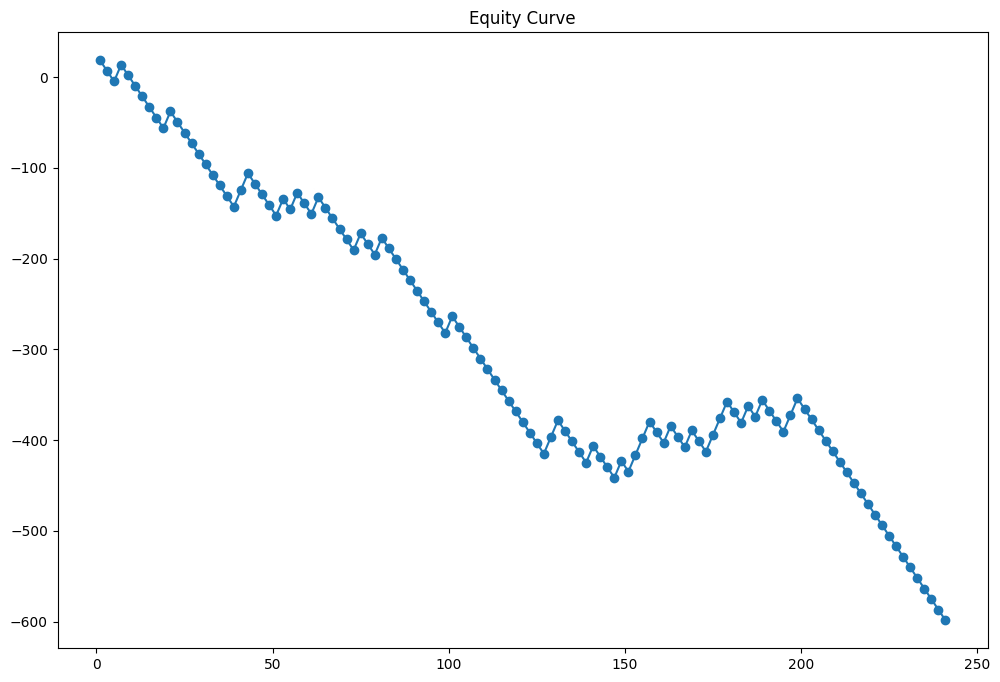

--------------------------------------------------
net profit: -598.44
profit_factor: 0.45
max_drawdown: -6.0%
annualized_sharpe_ratio: -6.19
annualized_sortino_ratio: NA (Deviation 0)
annualized_ulcer_index: 0.55
annualized_upi: -2275.13
percentaje_profitable: 22.31
--------------------------------------------------


/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/DeltaX/backtesting_base_mostoro.py:218: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  max_drawdown = round((((self.amount + profit_copy['Net_Profit']) / (self.amount + profit_copy['Net_Profit']).cummax() - 1).fillna(0).replace([-np.inf]).dropna()).min(), 2)
/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/DeltaX/backtesting_base_mostoro.py:237: RuntimeWarning: divide by zero encountered in scalar divide
  sortino_ratio = round(profit_copy['Profit'][profit_copy['Profit'] != 0].mean() / downside_deviation, 2)
/Users/mostoro/Library/CloudStorage/OneDrive-Personal/11 SHARING/Carpe Diem Society/Trading/PYTHON/MOSTORO/Code/Strategies/DeltaX/backtesting_base_mostoro.py:2

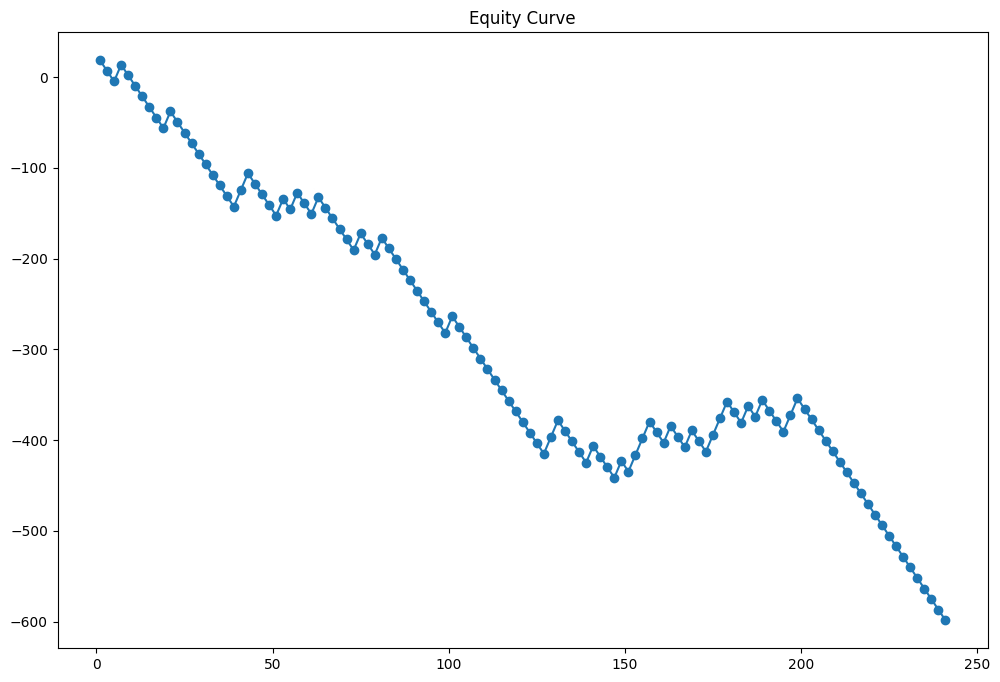

In [44]:
runner.profit['Profit'] = pd.to_numeric(runner.profit.get('Profit', 0), errors='coerce').astype(float).fillna(0.0)
runner.profit['Net_Profit'] = pd.to_numeric(
runner.profit['Net_Profit'] if 'Net_Profit' in runner.profit.columns else runner.profit['Profit'].cumsum(),
errors='coerce'
).astype(float).fillna(0.0)

back.Backtesting.metrics(runner)  # <- usa la función de la clase base sin error

back.Backtesting.metrics(runner)

### Trades Visualizer

In [ ]:
# ===================== Trades & Candlestick Visualizer (FINAL) =====================
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
import pandas as pd

# ------------- Build trades from backtesting log -------------
def build_trades_from_log(profit_df):
    p = profit_df.copy()
    p['Time'] = pd.to_datetime(p['Time'])
    p = p.sort_values('Time').reset_index(drop=True)

    trades, open_trade = [], None
    for _, r in p.iterrows():
        pos = int(r['Position']); t = r['Time']; px = float(r['Price'])
        if open_trade is None and pos in (1, -1):  # entry
            open_trade = {
                'pos': pos, 'side': 'Long' if pos == 1 else 'Short',
                't_in': t, 'p_in': px, 'stop': float(r['Stop']), 'target': float(r['Target']),
            }
            continue
        if open_trade is not None and pos == 0:     # exit
            open_trade.update({'t_out': t, 'p_out': px, 'profit_exit_row': float(r.get('Profit', 0.0))})
            trades.append(open_trade)
            open_trade = None
    return pd.DataFrame(trades)

# Build once from your backtesting log
trades = build_trades_from_log(backtesting_base.profit)

# ------------- Helpers -------------
def _plot_candles(ax, sub):
    if len(sub) > 1:
        dt_sec = (sub.index.to_series().diff().median()).total_seconds()
    else:
        dt_sec = 60
    barw = (dt_sec / 86400.0) * 0.8  # in days
    up = sub['close'] >= sub['open']
    down = ~up
    ax.vlines(sub.index, sub['low'], sub['high'], lw=0.8, alpha=0.8)
    ax.bar(sub.index[up], (sub.loc[up,'close']-sub.loc[up,'open']),
           bottom=sub.loc[up,'open'], width=barw, align='center',
           edgecolor='black', linewidth=0.6, color='green')
    ax.bar(sub.index[down], (sub.loc[down,'close']-sub.loc[down,'open']),
           bottom=sub.loc[down,'open'], width=barw, align='center',
           edgecolor='black', linewidth=0.6, color='red')
    return dt_sec

def _nearest_time(ts, idx):
    if ts in idx:
        return ts
    if len(idx) == 0:
        return None
    j = np.argmin(np.abs(idx.values.astype('datetime64[ns]') - np.datetime64(ts)))
    return idx[j]

def _session_extremes_so_far(day_df, t_start, t_end, mode='entry'):
    """
    Returns (high_so_far, low_so_far) depending on mode:
      - 'entry': extremes up to t_start
      - 'exit' : extremes up to t_end
      - 'window': extremes within [t_start, t_end] (plotted window)
    """
    if day_df.empty:
        return None, None
    if mode == 'entry':
        span = day_df.loc[day_df.index <= t_start]
    elif mode == 'exit':
        span = day_df.loc[day_df.index <= t_end]
    else:  # 'window'
        span = day_df.loc[(day_df.index >= t_start) & (day_df.index <= t_end)]
    if span.empty:
        return None, None
    return span['high'].max(), span['low'].min()

def _find_signal_bar_and_delta(df, t_in, is_long, sig_col_long='long_sig', sig_col_short='short_sig'):
    """
    Find the divergence 'signal bar' BEFORE entry and return (timestamp, delta).
    Priority:
      1) Last True in the matching signal column before t_in (long_sig / short_sig)
      2) If not found but a generic 'divergence' column exists, use that
      3) Fallback: bar immediately prior to t_in
    """
    # restrict to bars strictly before entry
    hist = df.loc[df.index < t_in]
    if hist.empty:
        return None, None

    # Helper to pick last True index from a bool column
    def _last_true_time(h, col):
        if col in h.columns:
            hh = h.loc[h[col].astype(bool)]
            if not hh.empty:
                return hh.index[-1]
        return None

    # 1) Match by side
    col = sig_col_long if is_long else sig_col_short
    t_sig = _last_true_time(hist, col)

    # 2) Generic divergence column
    if t_sig is None and 'divergence' in hist.columns:
        t_sig = _last_true_time(hist, 'divergence')

    # 3) Fallback: immediate prior bar
    if t_sig is None:
        # last bar strictly before entry
        t_sig = hist.index[-1]

    # Delta value
    delta_val = hist.loc[t_sig, 'delta'] if (t_sig is not None and 'delta' in hist.columns) else None
    return t_sig, delta_val

# ------------- Main plot -------------
def plot_trade(i, look_back='30min', look_ahead='30min',
               label_all_deltas=True, delta_label_threshold=150,
               extremes_scope='entry',
               sig_col_long='long_sig', sig_col_short='short_sig',
               show_entry_delta=False):
    """
    Visualize a trade with:
      - Candles + delta bars
      - Session extremes AS OF 'entry'/'exit'/'window'
      - Only the relevant extreme drawn (low for LONG, high for SHORT), both in legend
      - Δ Signal (divergence bar BEFORE entry) and Δ Exit in legend + annotated on delta plot
      - Optional: label large deltas across the window

    Params:
      extremes_scope: 'entry' (default), 'exit', or 'window'
      sig_col_long / sig_col_short: names of your divergence-signal columns
      show_entry_delta: if True, also include the entry-bar delta in legend
    """
    tr = trades.iloc[i]
    t_in, t_out = pd.to_datetime(tr['t_in']), pd.to_datetime(tr['t_out'])
    p_in, p_out = float(tr['p_in']), float(tr['p_out'])
    stop, target = float(tr['stop']), float(tr['target'])
    is_long = (tr['pos'] == 1)

    lb = pd.to_timedelta(look_back); la = pd.to_timedelta(look_ahead)
    t0, t1 = t_in - lb, max(t_out, t_in) + la
    sub = df.loc[(df.index >= t0) & (df.index <= t1)].copy()

    # --- Session extremes "as of" chosen scope ---
    # Prefer session column if present; otherwise derive by date on index
    if 'session' in df.columns:
        day = t_in.date()
        day_df = df[df['session'] == day]
    else:
        day_slice = df.loc[df.index.normalize() == pd.to_datetime(t_in.date())]
        day_df = day_slice

    hi_sofar, lo_sofar = _session_extremes_so_far(day_df, t_in, t_out, mode=extremes_scope)

    # --- P&L (MES defaults) ---
    pnl_points = (p_out - p_in) * (1 if is_long else -1)
    tick_size, tick_value = 0.25, 1.25  # MES
    pnl_ticks = pnl_points / tick_size
    pnl_cash_calc = pnl_ticks * tick_value
    pnl_cash_log = tr.get('profit_exit_row', None)

    fig, (ax_price, ax_delta) = plt.subplots(2, 1, figsize=(13, 7), sharex=True,
                                             gridspec_kw={'height_ratios':[3,1]})

    dt_sec = _plot_candles(ax_price, sub)

    # --- Price plot elements ---
    ax_price.axvspan(t_in, t_out, alpha=0.12, label='Trade duration')
    ax_price.scatter([t_in], [p_in], marker=('^' if is_long else 'v'), s=100, zorder=5,
                     color="#27BA31", label=f"Entry {p_in:.2f}")
    ax_price.scatter([t_out], [p_out], marker='x', s=100, zorder=6,
                     color="#CC0003", label=f"Exit {p_out:.2f}")

    ax_price.hlines(stop, t_in, t_out, linestyles=':', linewidth=0.6, color='red', label=f"Stop {stop:.2f}")
    ax_price.hlines(target, t_in, t_out, linestyles=':', linewidth=0.6, color = 'green',  label=f"Target {target:.2f}")

    # --- Draw only the relevant extreme, but keep both in legend (as-of wording) ---
    shown_extreme = None
    if is_long and (lo_sofar is not None):
        shown_extreme = lo_sofar
        ax_price.hlines(lo_sofar, sub.index.min(), sub.index.max(),
                        linestyles=':', linewidth=2.2, color='red',
                        label=f"Low (as of {extremes_scope}) {lo_sofar:.2f}")
        if hi_sofar is not None:
            ax_price.plot([], [], color='green', linestyle=':', linewidth=2.2,
                          label=f"High (as of {extremes_scope}) {hi_sofar:.2f}")
    elif (not is_long) and (hi_sofar is not None):
        shown_extreme = hi_sofar
        ax_price.hlines(hi_sofar, sub.index.min(), sub.index.max(),
                        linestyles=':', linewidth=2.2, color='green',
                        label=f"High (as of {extremes_scope}) {hi_sofar:.2f}")
        if lo_sofar is not None:
            ax_price.plot([], [], color='red', linestyle=':', linewidth=2.2,
                          label=f"Low  (as of {extremes_scope}) {lo_sofar:.2f}")
    else:
        # No line drawn, but keep legend if available
        if hi_sofar is not None:
            ax_price.plot([], [], color='green', linestyle=':', linewidth=2.2,
                          label=f"High (as of {extremes_scope}) {hi_sofar:.2f}")
        if lo_sofar is not None:
            ax_price.plot([], [], color='red', linestyle=':', linewidth=2.2,
                          label=f"Low  (as of {extremes_scope}) {lo_sofar:.2f}")

    # --- Y-limits: scale using only the shown extreme ---
    lim_candidates = [sub['low'].min(), sub['high'].max(), stop, target, p_in, p_out]
    if shown_extreme is not None:
        lim_candidates.append(shown_extreme)
    y_min = min([c for c in lim_candidates if np.isfinite(c)]) * 0.999
    y_max = max([c for c in lim_candidates if np.isfinite(c)]) * 1.001
    ax_price.set_ylim(y_min, y_max)

    # --- PnL label ---
    profit_text = f"PnL: {pnl_points:+.2f} pts ({pnl_ticks:+.0f} ticks) ≈ ${pnl_cash_calc:+.2f}"
    if pnl_cash_log is not None and not np.isnan(pnl_cash_log):
        profit_text += f" | Log: ${pnl_cash_log:+.2f}"
    ax_price.text(0.01, 0.98, profit_text, transform=ax_price.transAxes, va='top', fontsize=10,
                  bbox=dict(boxstyle='round', fc='white', alpha=0.7))

    ax_price.set_title(f"Trade #{i}  |  {'LONG' if is_long else 'SHORT'}  |  {t_in} → {t_out}")
    ax_price.set_ylabel("Price")
    ax_price.grid(alpha=0.25)

    # ---------- Delta subplot ----------
    ax_delta.bar(sub.index, sub['delta'], width=timedelta(seconds=dt_sec), align='center')
    ax_delta.axhline(0, lw=0.8)
    ax_delta.set_ylabel("Δ (Ask - Bid)")
    ax_delta.grid(alpha=0.25)

    # --- Signal (divergence) delta & Exit delta ---
    # 1) Signal bar: last divergence signal BEFORE entry
    t_sig, sig_delta = _find_signal_bar_and_delta(df, t_in, is_long,
                                                  sig_col_long=sig_col_long,
                                                  sig_col_short=sig_col_short)

    if t_sig is not None and sig_delta is not None and t_sig in sub.index:
        ax_delta.annotate(f"Δ signal: {sig_delta:.0f}",
                          xy=(t_sig, sig_delta),
                          xytext=(0, 12), textcoords='offset points',
                          ha='center', fontsize=9, color='purple')
        # Legend entry (blank handle)
        ax_price.plot([], [], ' ', label=f"Δ Signal (div): {sig_delta:.0f}")

    # 2) Exit delta (nearest)
    if not sub.empty:
        t_out_n = _nearest_time(t_out, sub.index)
        if t_out_n is not None:
            exit_delta = sub.loc[t_out_n, 'delta']
            ax_delta.annotate(f"Δ exit: {exit_delta:.0f}",
                              xy=(t_out_n, exit_delta),
                              xytext=(0, 12), textcoords='offset points',
                              ha='center', fontsize=9)
            ax_price.plot([], [], ' ', label=f"Δ Exit: {exit_delta:.0f}")

    # (Optional) 3) Entry-bar delta (if you still want to see it)
    if show_entry_delta and not sub.empty:
        t_in_n = _nearest_time(t_in, sub.index)
        if t_in_n is not None:
            entry_delta = sub.loc[t_in_n, 'delta']
            ax_delta.annotate(f"Δ entry: {entry_delta:.0f}",
                              xy=(t_in_n, entry_delta),
                              xytext=(0, 12), textcoords='offset points',
                              ha='center', fontsize=9)
            ax_price.plot([], [], ' ', label=f"Δ Entry: {entry_delta:.0f}")

    # Optional: label all big deltas in the window
    if label_all_deltas and not sub.empty:
        yspan = max(1.0, (sub['delta'].max() - sub['delta'].min()))
        for x, y in zip(sub.index, sub['delta'].values):
            if abs(y) >= delta_label_threshold:
                ax_delta.text(x, y + 0.02 * yspan, f"{y:.0f}",
                              ha='center', va='bottom', fontsize=8, rotation=90)

    # Final legend
    ax_price.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

# ---- Usage examples ----
# plot_trade(0)  # entry-time extremes, Δ Signal + Δ Exit in legend
# plot_trade(0, extremes_scope='exit')
# plot_trade(0, extremes_scope='window', label_all_deltas=False)
# plot_trade(0, sig_col_long='my_long_div', sig_col_short='my_short_div')
# plot_trade(0, show_entry_delta=True)  # if you also want entry-bar delta


In [ ]:
plot_trade(22, label_all_deltas=True,  delta_label_threshold=150)


### DRAFT

### Comments


* Minimum Delta Threshold
* Try divergence and stack inbalance (at least 3 inbalances) after the divergence pattern
* filter it by just really strong delta divergences (strong price, volume, delta, ratio, etc)
* Continuation with strengh (delta, volume, imbalances)
* Estrategia con volumen mayor que el anterior y stacked imbalance 
* Add a break-even stop once price reaches +4 pts.
* Test with more data
* Analyze chart by chart (trade by trade) and determine why the winners win
* Test other instruments

### Analysis Applied